<a href="https://colab.research.google.com/github/halldm2000/NOAA-AI-2020-TUTORIAL/blob/master/curve_fit_wind_vs_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Python Package for reading NetCDF files**

In [73]:
!pip install -q netCDF4

**Download Data from NOAA**

In [74]:
import os
source = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc"
dest    = "data/ibtracs/"
!wget -q -c -e robots=off -P {dest} {source}

**Read Cyclone Data From File**

In [75]:
import xarray as xr, numpy as np

# read data from file
ds   = xr.open_dataset("/content/data/ibtracs/IBTrACS.ALL.v04r00.nc")
wind = ds['usa_wind'].data
pres = ds['usa_pres'].data

# find indices where both variables are valid
wind_valid = ~np.isnan(wind)
pres_valid = ~np.isnan(pres)
valid      = np.logical_and(pres_valid,wind_valid)

# keep only valid data
wind = wind[valid]
pres = pres[valid]

**Plot Pressure vs Windspeed**

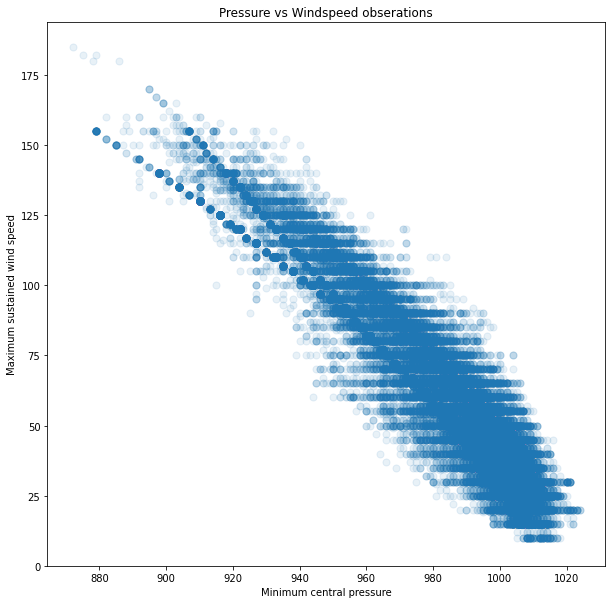

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(pres,wind,s=50,alpha=0.1)
plt.title("Pressure vs Windspeed obserations")
plt.xlabel(ds['usa_pres'].long_name)
plt.ylabel(ds['usa_wind'].long_name);
plt.ylim(bottom=0);

**Define routine for plotting curve-fit and training loss**

In [70]:
def plot_fit_and_loss(train_loss):

  # generate evenly spaced input points

  x     = np.linspace(850,1025,200, dtype=np.float32)
  x     = np.reshape(x,(-1,1))
  input = xscaler.transform(x)
  input = torch.from_numpy(input)
  pred  = model(input)
  y     = yscaler.inverse_transform(pred)

  plt.figure(figsize=(10,5), dpi=72*1.5)
 
  # plot observations and fit
  plt.subplot(1, 2, 1)
  plt.scatter(pres,wind,s=50,alpha=0.1)
  plt.plot(x,y,color='orange', linewidth=3)
  plt.xlabel(ds['usa_pres'].long_name)
  plt.ylabel(ds['usa_wind'].long_name);
  plt.ylim(bottom=0)

  if len(train_loss) > 0:
    # plot training loss vs batch number
    plt.subplot(1, 2, 2)
    plt.semilogy(train_loss)
    plt.xlabel("batch number")
    plt.ylabel("training loss")
    plt.ylim(bottom=1e-2)

  plt.show()


**Train a neural net to fit the observations**

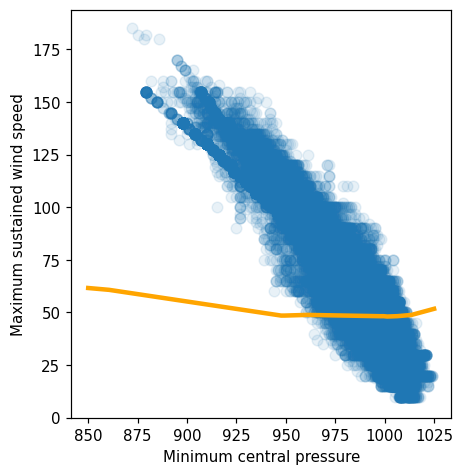

epoch=0 training loss=0.10042032599449158 dt=1.31


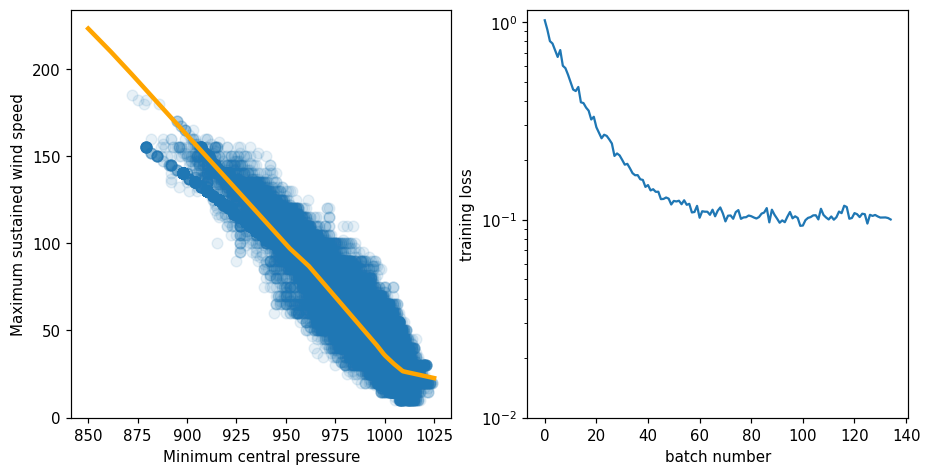

epoch=1 training loss=0.09856438636779785 dt=1.21


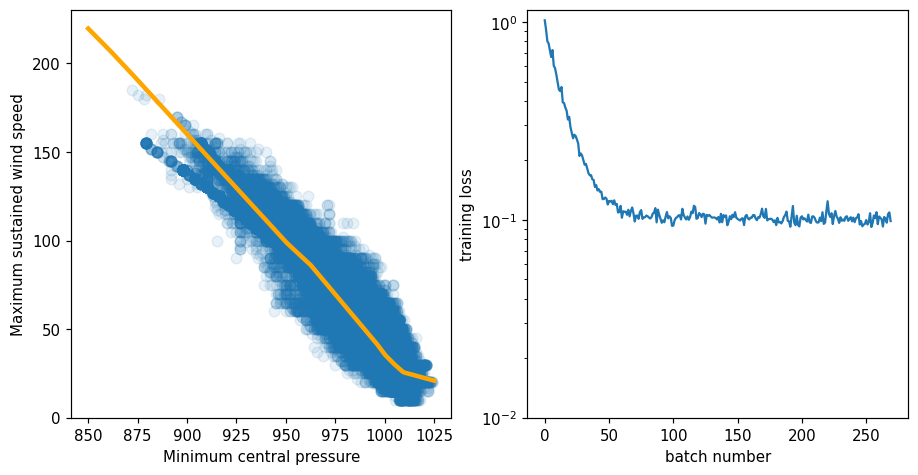

epoch=2 training loss=0.09757768362760544 dt=1.20


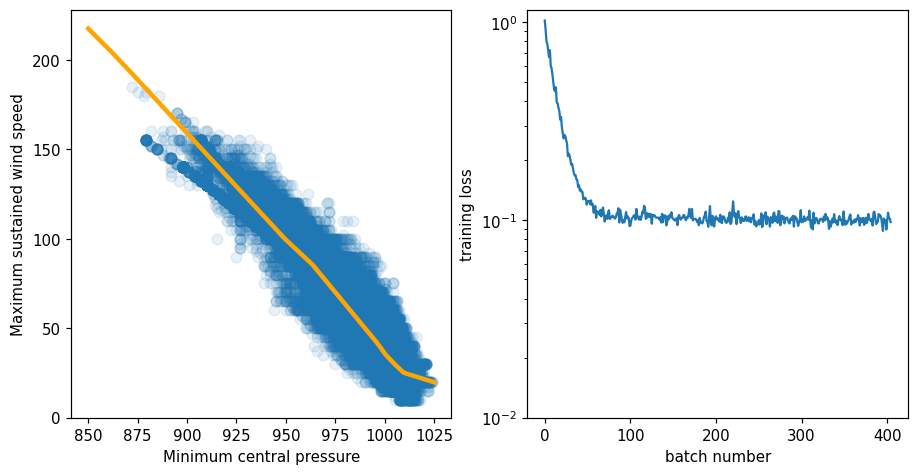

epoch=3 training loss=0.0970892384648323 dt=1.11


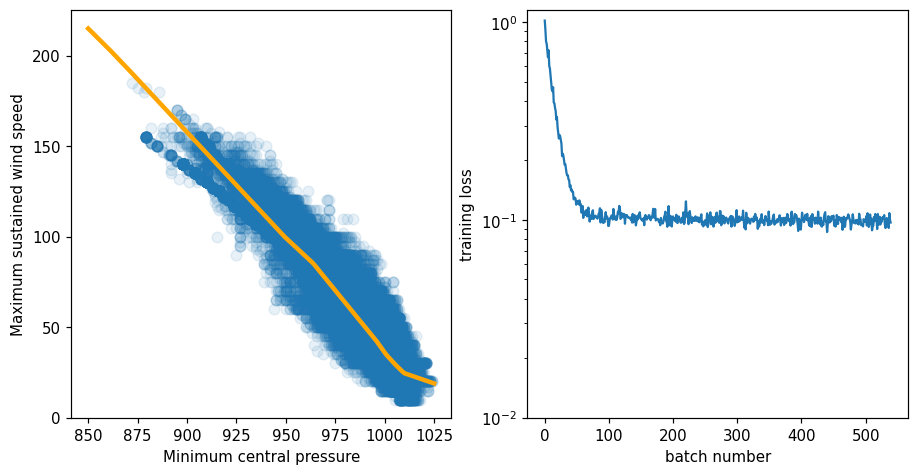

epoch=4 training loss=0.10506558418273926 dt=1.18


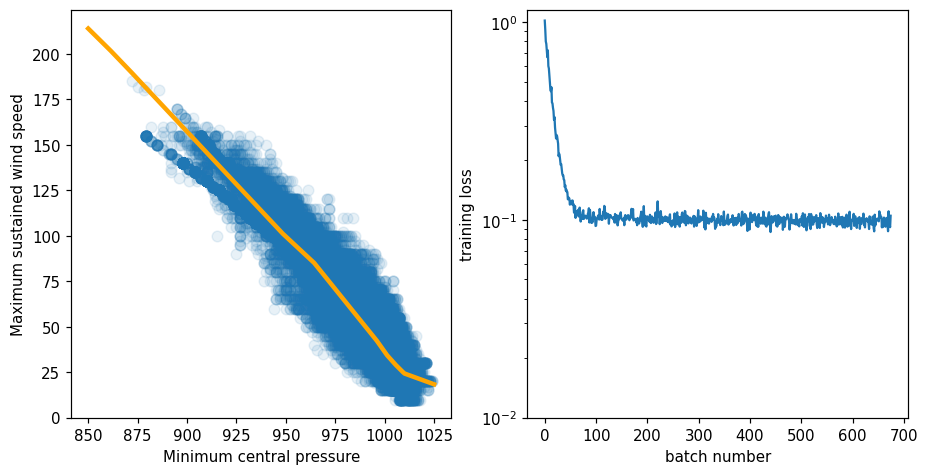

epoch=5 training loss=0.09875251352787018 dt=1.18


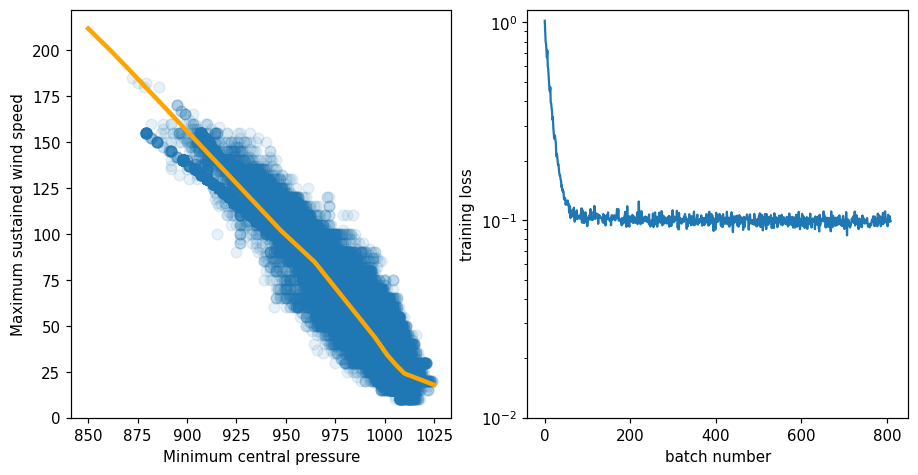

epoch=6 training loss=0.10341687500476837 dt=1.17


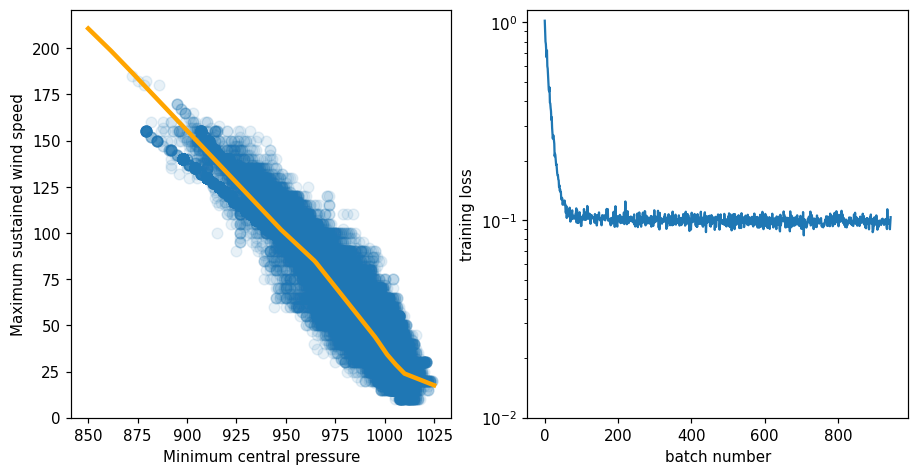

epoch=7 training loss=0.09237809479236603 dt=1.21


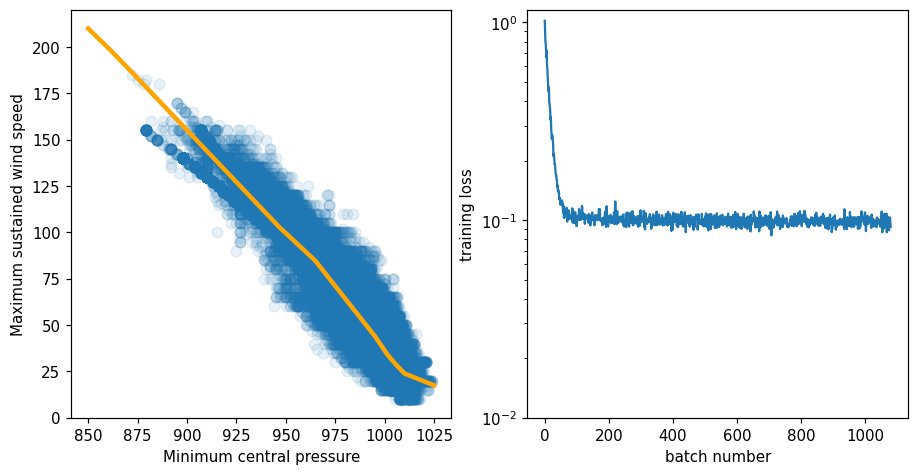

epoch=8 training loss=0.09725432842969894 dt=1.20


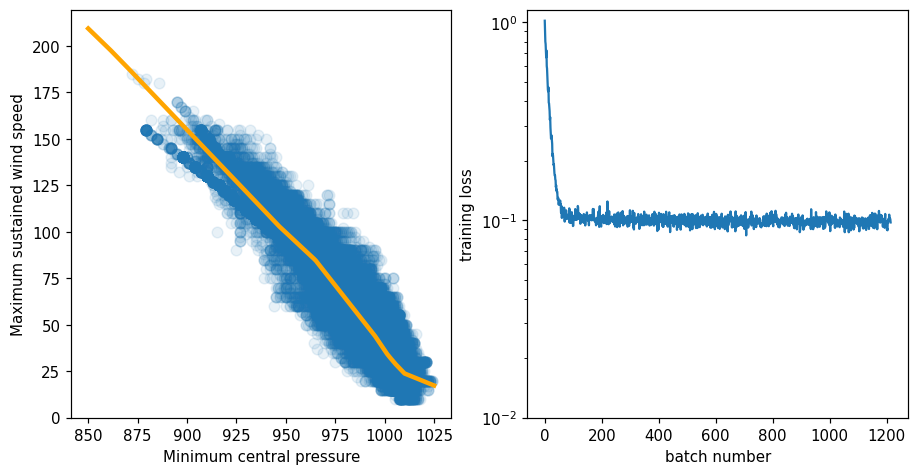

epoch=9 training loss=0.09529007226228714 dt=1.18


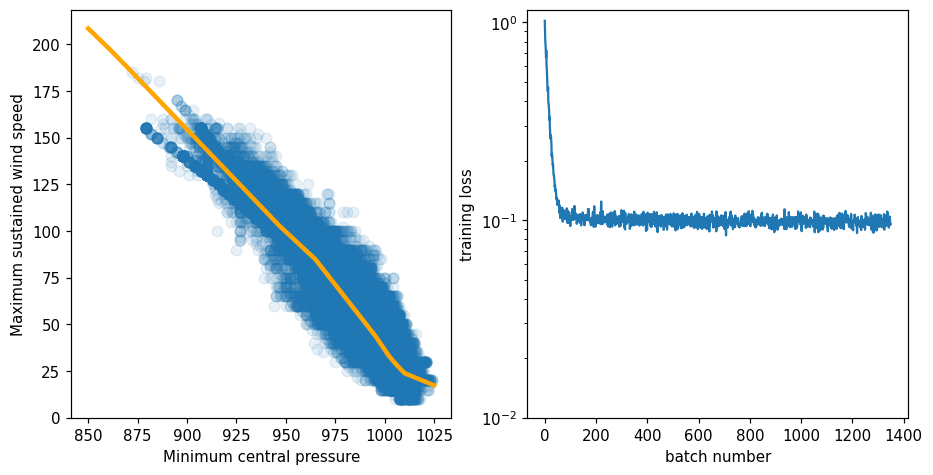

epoch=10 training loss=0.09531346708536148 dt=1.13


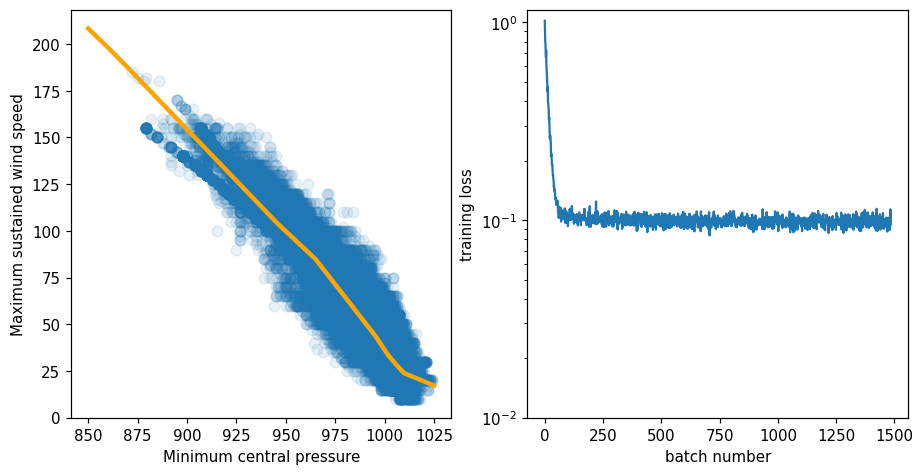

epoch=11 training loss=0.0939728394150734 dt=1.16


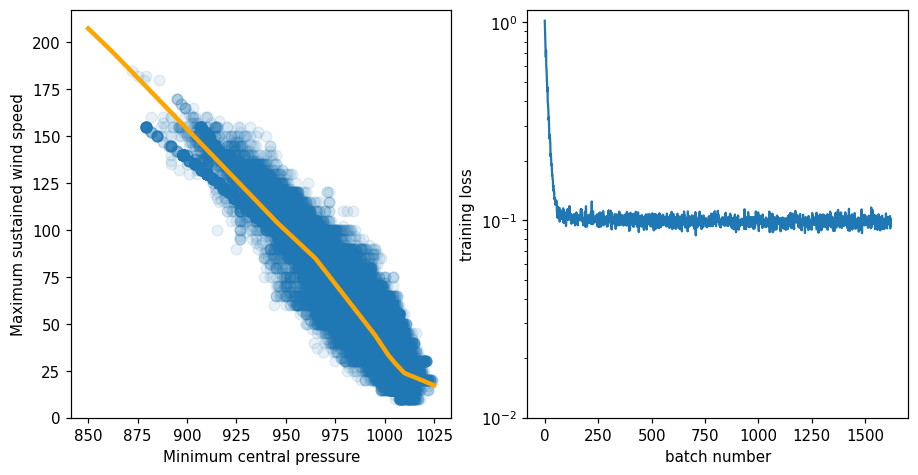

epoch=12 training loss=0.08759110420942307 dt=1.19


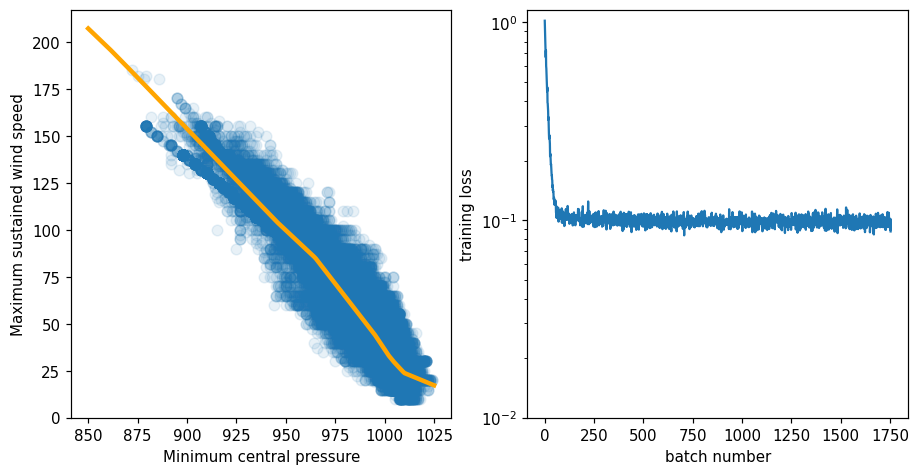

epoch=13 training loss=0.0930727943778038 dt=1.09


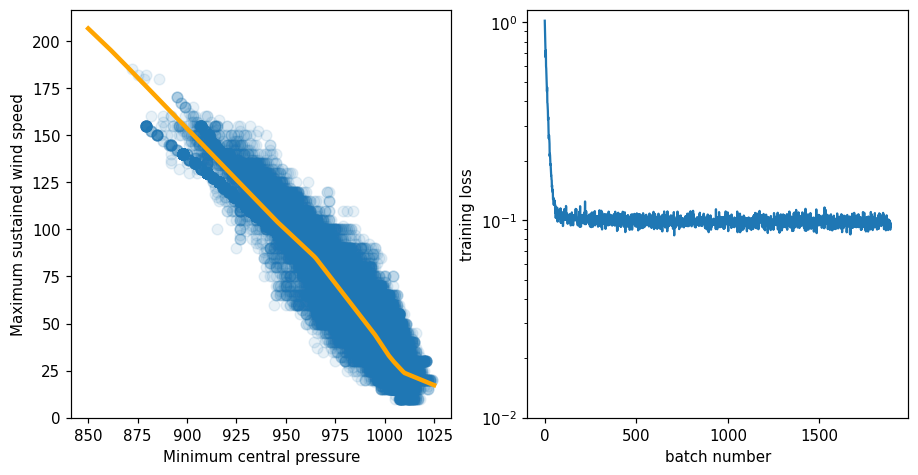

epoch=14 training loss=0.09545762836933136 dt=1.21


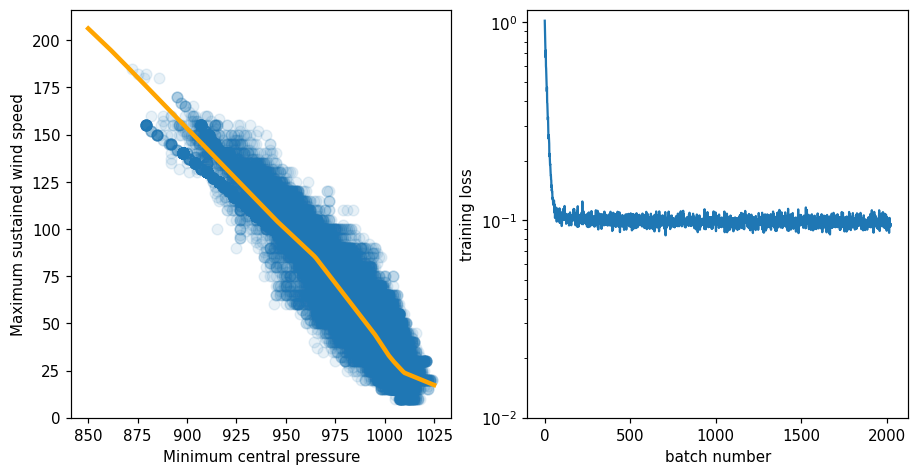

epoch=15 training loss=0.10508978366851807 dt=1.10


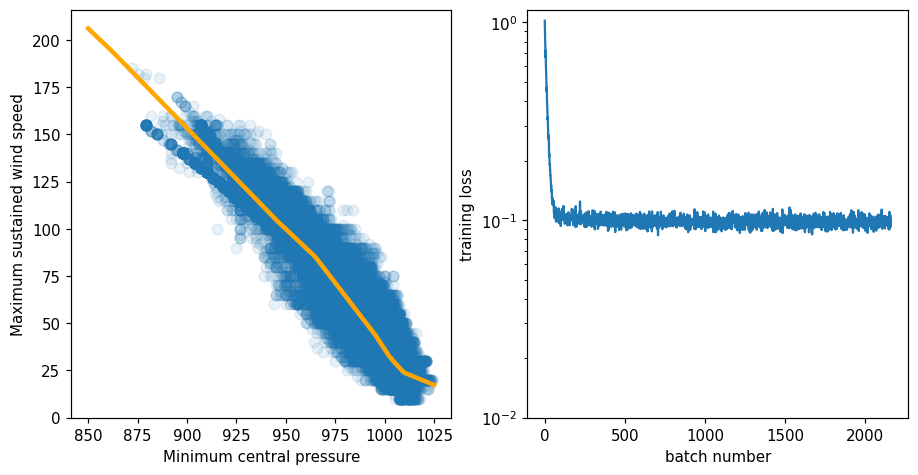

epoch=16 training loss=0.09742171317338943 dt=1.18


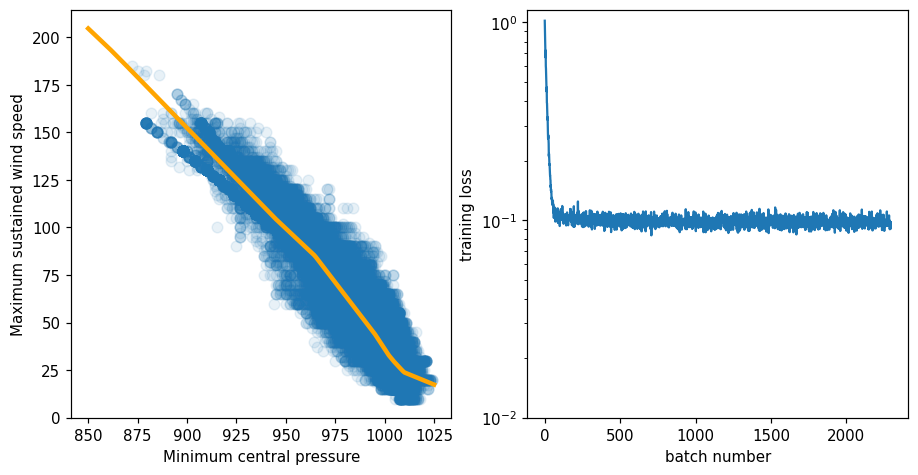

epoch=17 training loss=0.10551487654447556 dt=1.28


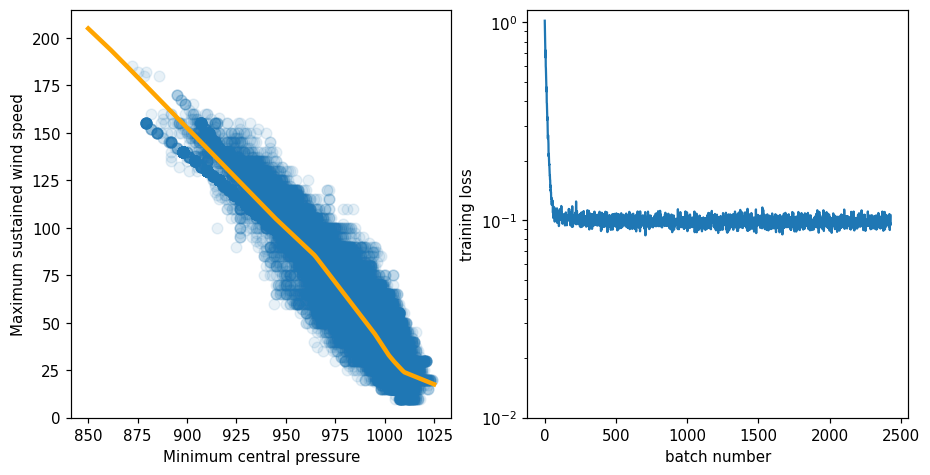

epoch=18 training loss=0.09231770783662796 dt=1.18


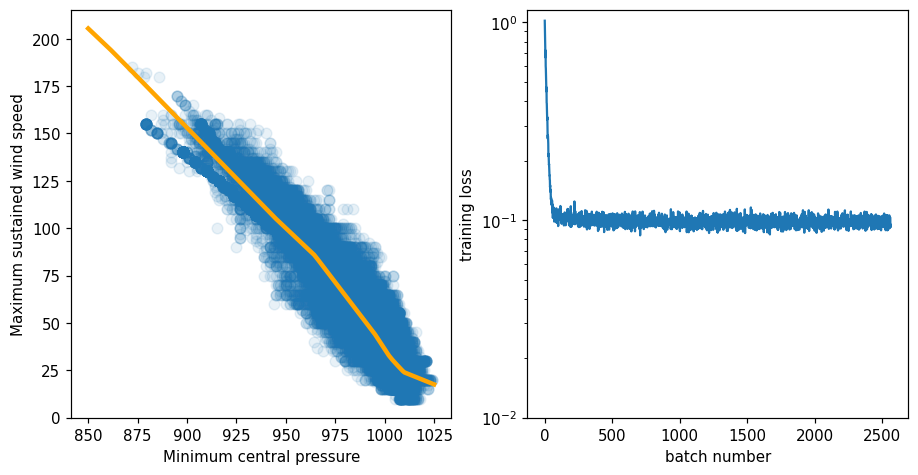

epoch=19 training loss=0.0998295322060585 dt=1.18


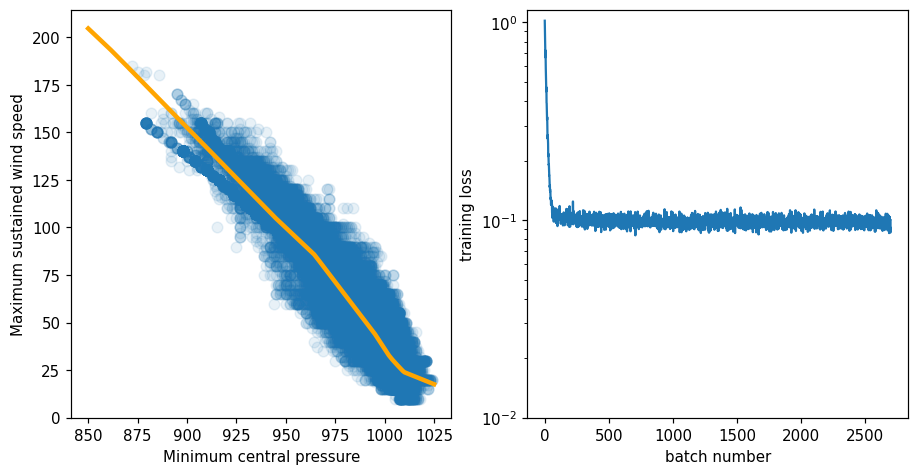

In [77]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.optim as optim, torch.utils.data as data
from sklearn.preprocessing import StandardScaler

import time

# DATA

# reshape data to (nsamples, nvariables)
x = pres.reshape(-1,1)
y = wind.reshape(-1,1)

# normalize data
xscaler = StandardScaler()
yscaler = StandardScaler()

X = xscaler.fit_transform(x)
Y = yscaler.fit_transform(y)

# create a pytorch dataset and data loader from the numpy arrays
X = torch.tensor(X)
Y = torch.tensor(Y)
train_dataset = data.TensorDataset(X, Y)
train_loader  = data.DataLoader(train_dataset, batch_size=1000, shuffle=True, num_workers=0)

# MODEL

N = 10
model = nn.Sequential(
    nn.Linear(1  ,N), 
    nn.ReLU(),
    nn.Linear(N,1  )
)

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fcn  = nn.MSELoss() # mean-squared error loss

# TRAIN

losses = []

# plot initial, random curve fit
with torch.no_grad(): plot_fit_and_loss(losses)

for epoch in range(20):

  t =time.time()
  model.train()

  for i, (input,target) in enumerate(train_loader):

    # get model prediction
    prediction = model(input)
    
    # adjust model parameters
    optimizer.zero_grad()
    train_loss = loss_fcn(prediction,target)
    train_loss.backward()
    optimizer.step()
    losses.extend([train_loss.item()])

  # plot curve fit and training loss

  model.eval()

  # print loss and time to train one epoch
  dt = time.time()- t 
  print(f"epoch={epoch} training loss={train_loss.item()} dt={dt:.2f}")#,end="\r")
    
  # plot training data, curve fit, and training loss
  with torch.no_grad(): plot_fit_and_loss(losses)
